# Time Elastic Similarity Spaces for Time Series Mining

In this project, we implemented a number of tasks to evaluate different elastic similarity spaces for string, and signature verification. We started with the Levenshtein's distance and then considered the Euclidean space, DTW, Frechet and KDTW similarity spaces for signature verification. See the implementation as follows.

### Workspace utilities

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import pathlib
import numpy as np
import pandas as pd
from dtw import *

import zipfile

from sklearn.metrics import average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import collections
import pickle

# compute dtw value
from dtw import *
import dfrechet as frechet
from kdtw import *

import pathlib
import pandas as pd


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



#### Data Loading Functions provided by Professor Francois PM.

In [2]:
# Data Loading
# -*- coding: utf-8 -*-
"""
Created on Sat Aug  3 16:41:48 2019

@author: pfm
"""
import numpy as np
import matplotlib.pyplot as plt
import glob, os, sys
import re, math
import argparse
from collections import Counter
from statistics import mode


def normalizeMaxMin(V):
    M=np.max(V)
    m=np.min(V)
    V=(V-m)/(M-m)
    return V
    
def convertLine(l1):
    lout=[]
    l1=l1.split(' ')
    for e in l1:
        lout.append(float(e))
    return np.array(lout)


def convertLineMOBISIG(l1):
    lout=[]
    l1=re.split(' |,|;|\n|\t|\0',l1)
    #l1=l1.split(' ')
    ii=0
    if len(l1)>1:
        for e in l1:
            if e!="":
                if ii!=2 and ii!=4:
                    lout.append(float(e))
                ii+=1
                if ii==7:
                    break
    return np.array(lout)
    
    
def loadFile(fname, removeMean=True, withSpeed=False, withAcceleration=False):
    f = open(fname, 'r')
    lines=f.readlines()
    L=len(lines)
    data=[]
    for i in range(L):
        d=convertLine(lines[i])
        data.append(d)
    data = np.array(data)
    if withSpeed:
        dim=len(data[0])
        D=np.zeros((len(data),dim+2))
        for i in range(len(data)):
            D[i,0:dim]=data[i,:]
            if i>0:
                D[i,dim]=data[i,0]-data[i-1,0]
                D[i,dim+1]=data[i,1]-data[i-1,1]
        data=D

    dim=len(data[0])
    m=np.zeros(dim)
    if removeMean:
        sigma=np.zeros(dim)
        for k in range(dim):
            m[k]=np.mean(data[:,k])
            sigma[k]=np.std(data[:,k])
            data[:,k]=(data[:,k]-m[k])/sigma[k]
      
    if removeMean:
        M=np.zeros(dim)
        for k in range(dim):
            m[k]=np.min(data[:,k])
            M[k]=np.max(data[:,k])
            data[:,k]=(data[:,k]-m[k])/(M[k]-m[k])
            
    # Suppress Z==0
    D=[]
    for i in range(len(data)):
       if data[i,2]>.01:
           D.append(data[i,:])
    data=np.array(D)
    dim=len(data[0])
    if removeMean:
        sigma=np.zeros(dim)
        for k in range(dim):
            m[k]=np.mean(data[:,k])
            sigma[k]=np.std(data[:,k])
            data[:,k]=(data[:,k]-m[k])/sigma[k]

    return data

    
def loadFileMOBISIG(fname, removeMean=True, path='./DATA/'):
    f = open(fname, 'r')
    lines=f.readlines()
    L=len(lines)
    data=[]
    for i in range(1,L):
        if lines[i]!="\n":
          d=convertLineMOBISIG(lines[i])
          data.append(d)
    data = np.array(data)
    dim=len(data[0])
    m=np.zeros(dim)
    sigma=np.zeros(dim)
    '''if removeMean:

        for k in range(dim):
            m[k]=np.mean(data[:,k])
            sigma[k]=np.std(data[:,k])
            data[:,k]=(data[:,k]-m[k])/sigma[k]'''
      
    if removeMean:
        M=np.zeros(dim)
        for k in range(dim):
            m[k]=np.min(data[:,k])
            M[k]=np.max(data[:,k])
            data[:,k]=(data[:,k]-m[k])/(M[k]-m[k]) 
    # Suppress Z==0
    D=[]
    for i in range(len(data)):
       if data[i,2]>0:#.25:
           '''d=[]
           for k in range(dim):
               if k!=2:
                   d.append(data[i,k])
           D.append(np.array(d))'''
           D.append(data[i,:])
    data=np.array(D)
    dim=len(data[0])
    if removeMean:
        for k in range(dim):
            m[k]=np.mean(data[:,k])
            sigma[k]=np.std(data[:,k])
            data[:,k]=(data[:,k]-m[k])/sigma[k]  

    return data


def getGenuinesTrainTest_MOBISIG(uid, ntrain=5, path='./DATA/'):
    path += uid
    os.chdir(path)
    lfiles=[]
    for file in glob.glob("SIGN_GEN_*.csv"):
        lfiles.append(file)
    lfiles=sorted(lfiles)
    #I=np.arange(len(lfiles))
    np.random.shuffle(lfiles)
    if ntrain>len(lfiles)-1:
        ntrain=len(lfiles)-1
    genuineTrainFiles=lfiles[0:ntrain]
    genuineTestFiles=lfiles[ntrain:]
    return genuineTrainFiles, genuineTestFiles

def getForgeriesTest_MOBISIG(uid, path='./DATA/'):
    path += uid
    os.chdir(path)
    lfiles=[]
    for file in glob.glob("SIGN_FOR_*.csv"):
        lfiles.append(file)
    lfiles=sorted(lfiles)
    return lfiles


def loadTrainQuestionnedMOBISIG(uid, ntrain=5, path='./DATA/', seed=42):
    np.random.seed(seed=seed)
    lgtrain, lgtest = getGenuinesTrainTest_MOBISIG(uid, ntrain=ntrain, path=path)
    lftest = getForgeriesTest_MOBISIG(uid, path=path)
    path += uid + '/'
    os.chdir(path)
    dataT=[]
    for file in lgtrain:
        d=loadFileMOBISIG(path+file)
        dataT.append(d)

    data=[]
    yq=[]
    for file in lgtest:
        d=loadFileMOBISIG(path+file)
        data.append(d)
        yq.append(0)

    for file in lftest:
        d=loadFileMOBISIG(path+file)
        data.append(d)
        yq.append(1)
    return np.array(dataT), np.array(data), yq

def processProblem(uid, X_train, X_test, y_test):
    print('Processing problem:', uid, '...')
    ## TO DO
    ##


    

# set the correct path
path0='C:/Users/rufai/OneDrive/Desktop/School/UBS/Big Data/Data Mining/Time Elastic Kernels'
path=path0 + '/MOBISIG/'
os.chdir(path)
print('path:',path)
luid = glob.glob("USER*")
luid.sort()

# load first USER data
uid=luid[1]
print(path0)
X_train, X_test, y_test = loadTrainQuestionnedMOBISIG(uid, ntrain=5, path=path) 

# filter warnings
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

path: C:/Users/rufai/OneDrive/Desktop/School/UBS/Big Data/Data Mining/Time Elastic Kernels/MOBISIG/
C:/Users/rufai/OneDrive/Desktop/School/UBS/Big Data/Data Mining/Time Elastic Kernels


<ipython-input-2-62f93f251c46>:193: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(dataT), np.array(data), yq


#### KDTW Function by Prof. Francois P.M. 

kdtw(A,B)= 1.537005985616231e-07
kdtw(A,C)= 4.834989439190215e-16
kdtw(B,C)= 2.2202878370415724e-14


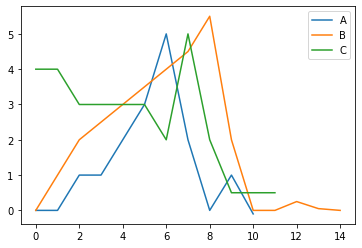

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Sep 27 16:46:45 2020
@author: pfm
"""
import numpy as np
# Filename: kdtw.py
# Python source code for the "Kernelized" Dynamic Time Warping similarity (as defined in the reference below).
# Author: Pierre-Francois Marteau
# Version: V1.0 du 13/09/2014, 
# Licence: GPL
# ******************************************************************
# This software and description is free delivered "AS IS" with no 
# guaranties for work at all. Its up to you testing it modify it as 
# you like, but no help could be expected from me due to lag of time 
# at the moment. I will answer short relevant questions and help as 
# my time allow it. I have tested it played with it and found no 
# problems in stability or malfunctions so far. 
# Have fun.
# *****************************************************************
# Please cite as:
# @article{marteau:hal-00486916,
#   AUTHOR = {Marteau, Pierre-Francois and Gibet, Sylvie},
#   TITLE = {{On Recursive Edit Distance Kernels with Application to Time Series Classification}},
#   JOURNAL = {{IEEE Transactions on Neural Networks and Learning Systems}},
#   PAGES = {1-14},
#   YEAR = {2014},
#   MONTH = Jun,
#   KEYWORDS = {Elastic distance, Time warp kernel, Time warp inner product, Definiteness, Time series classification, SVM},
#   DOI = {10.1109/TNNLS.2014.2333876},
#   URL = {http://hal.inria.fr/hal-00486916}
# } 
# 
''''
# function kdtw(A, B, sigma, epsilon=1e-3)
# Dynamic programming implementation of KDTW kernel
# input A: first multivariate time series: array of array (nxd), n is the number of sample, d is the dimension of each sample
# intput B: second multivariate time series: array of array (nxd), n is the number of sample, d is the dimension of each sample
# input sigma: >0 used in the exponential local kernel 
# output similarity: similarity between A and B (the higher, the more similar)
'''
from scipy.spatial.distance import cdist
import numpy as np

def kdtw_lk(A, B, local_kernel):
    d=np.shape(A)[1]
    Z=[np.zeros(d)]
    A = np.concatenate((Z,A), axis=0)
    B = np.concatenate((Z,B), axis=0)
    [la,d] = np.shape(A)
    [lb,d] = np.shape(B)
    DP = np.zeros((la,lb))
    DP1 = np.zeros((la,lb));
    DP2 = np.zeros(max(la,lb));
    l=min(la,lb);
    DP2[1]=1.0;
    for i in range(1,l):
        DP2[i] = local_kernel[i-1,i-1];

    DP[0,0] = 1;
    DP1[0,0] = 1;
    n = len(A);
    m = len(B);

    for i in range(1,n):
        DP[i,1] = DP[i-1,1]*local_kernel[i-1,2];
        DP1[i,1] = DP1[i-1,1]*DP2[i];

    for j in range(1,m):
        DP[1,j] = DP[1,j-1]*local_kernel[2,j-1];
        DP1[1,j] = DP1[1,j-1]*DP2[j];

    for i in range(1,n):
        for j in range(1,m): 
            lcost=local_kernel[i-1,j-1];
            DP[i,j] = (DP[i-1,j] + DP[i,j-1] + DP[i-1,j-1]) * lcost;
            if i == j:
                DP1[i,j] = DP1[i-1,j-1] * lcost + DP1[i-1,j] * DP2[i] + DP1[i,j-1]  *DP2[j]
            else:
                DP1[i,j] = DP1[i-1,j] * DP2[i] + DP1[i,j-1] * DP2[j];
    DP = DP + DP1;
    return DP[n-1,m-1]

def kdtw(A, B, sigma = 1.0, epsilon = 1e-3):
    distance = cdist(A, B, 'sqeuclidean')
    local_kernel = (np.exp(-distance/sigma)+epsilon)/(3*(1+epsilon))
    return kdtw_lk(A,B,local_kernel)
    
# Simple test
if __name__ == '__main__':
    import matplotlib.pyplot as plt
    A = np.array([[0],[0],[1],[1],[2],[3],[5],[2],[0],[1],[-0.1]])
    B = np.array([[0],[1],[2],[2.5],[3],[3.5],[4],[4.5],[5.5],[2],[0],[0],[.25],[.05],[0]])
    C = np.array([[4],[4],[3],[3],[3],[3],[2],[5],[2],[.5],[.5],[.5]])
    
    print("kdtw(A,B)=", kdtw(A,B,1))
    print("kdtw(A,C)=", kdtw(A,C,1))
    print("kdtw(B,C)=", kdtw(B,C,1))
        
    plt.plot(A, label='A')
    plt.plot(B, label='B')
    plt.plot(C, label='C')
    plt.legend()
    plt.show()

### Question 01
-- -- --- -- -- --- -- -- --- -- -- --- -- -- --- -- -- --- -- -- --- -- -- --- -- -- ---

### Levenshtein's distance of the strings "aBigRedHat" and "aRedBigHat". 
Draw the alignment matrix to evaluate the pairwise Levenshtein's distance of the strings "aBigRedHat" and "aRedBigHat" using the following cost:
- i. deletion/insertion = 1, 
- ii. substition = 2, 
- iii. match = 0.
Document your observations.

In [4]:
import re, ast
import pandas as pd

In [8]:
# function to compute the levenshtein's
import numpy as np

def min_ed_dis(first,second):
    #build an empty matrix of correct size
    first = [k for k in first]
    second = [k for k in second]
    matrix = np.zeros((len(first),len(second)))
    
    #first row & column
    matrix[0] = [j for j in range(len(first))]
    matrix[:,0] = [j for j in range(len(second))]
    
    #add anchor value
    if first[1] != second[1]:
        matrix[1,1] = 2
        
    #through every column
    for c in range(1, len(first)):
        #through every row
        for r in range(1, len(second)):
            
            #not same letter
            if first[c] != second[r]:
                matrix[r,c] = min(matrix[r-1, c], matrix[r, c-1])+1
            
            #same letter
            else:
                matrix[r,c] = matrix[r-1,c-1]
    return matrix

In [10]:
a = 'aBigRedHat'
b = 'aRedBigHat'

print("Levenshtein's/ Edit Distance Matrix: \n", min_ed_dis(a, b))

Levenshtein's/ Edit Distance Matrix: 
 [[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [1. 2. 3. 4. 3. 4. 5. 6. 7. 8.]
 [2. 3. 4. 5. 4. 3. 4. 5. 6. 7.]
 [3. 4. 5. 6. 5. 4. 3. 4. 5. 6.]
 [4. 3. 4. 5. 6. 5. 4. 5. 6. 7.]
 [5. 4. 3. 4. 5. 6. 5. 6. 7. 8.]
 [6. 5. 4. 3. 4. 5. 6. 7. 8. 9.]
 [7. 6. 5. 4. 5. 6. 7. 6. 7. 8.]
 [8. 7. 6. 5. 6. 7. 8. 7. 6. 7.]
 [9. 8. 7. 6. 7. 8. 9. 8. 7. 6.]]


In [7]:
def levenshtein(a, b):
    if not a: return len(b)
    if not b: return len(a)
    return min(levenshtein(a[1:], b[1:])+(a[0] != b[0]),
               levenshtein(a[1:], b)+1,
               levenshtein(a, b[1:])+1)

    
print(levenshtein(a,b))

6


The Levenshtein's distance is therefore 6 and the minimal cut is observed to be along [0, 1, 2, 3, 3, 3, 3, 5, 7, 9, 9, 9, 9]

### Question 02:
-- -- --- -- -- --- -- -- --- -- -- --- -- -- --- -- -- --- -- -- --- -- -- --- -- -- ---

#### Display signatures for five random users

In [13]:
def signature_overlay():
    fig, axs = plt.subplots(1, 5, figsize = (24, 4))
    length = range(len(X_train))
    for l, ax in zip(length, axs.ravel()):
        plt.plot(X_train[l][:, 0], X_train[l][:, 1], label = "Genuine signature")
        plt.plot(X_test[l][:, 0], X_test[l][:, 1], label = "Random signature")
        plt.legend()
        plt.sca(ax=ax)

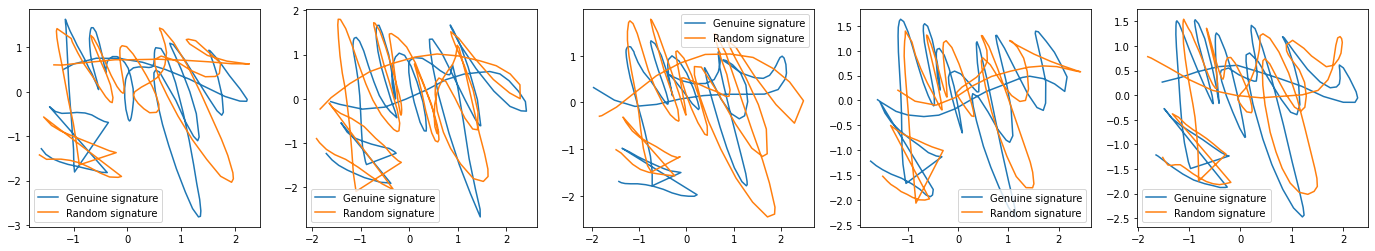

In [14]:
signature_overlay()

path: C:\Users\rufai\OneDrive\Desktop\School\UBS\Big Data\Data Mining\Time Elastic Kernels\MOBISIG\USER10


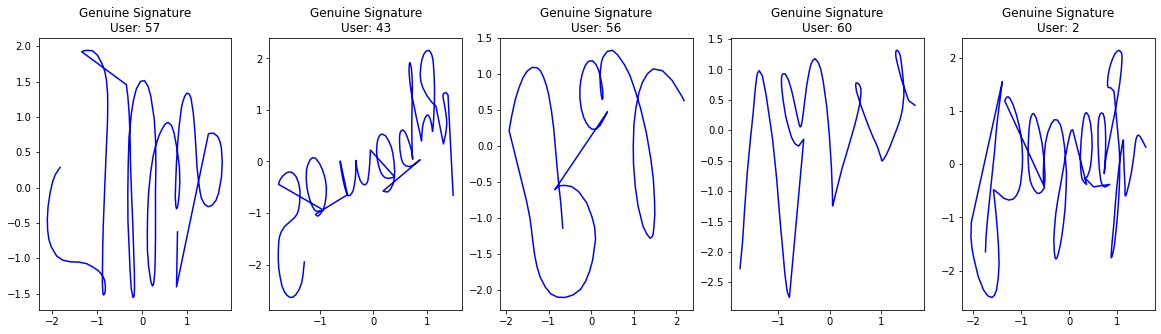

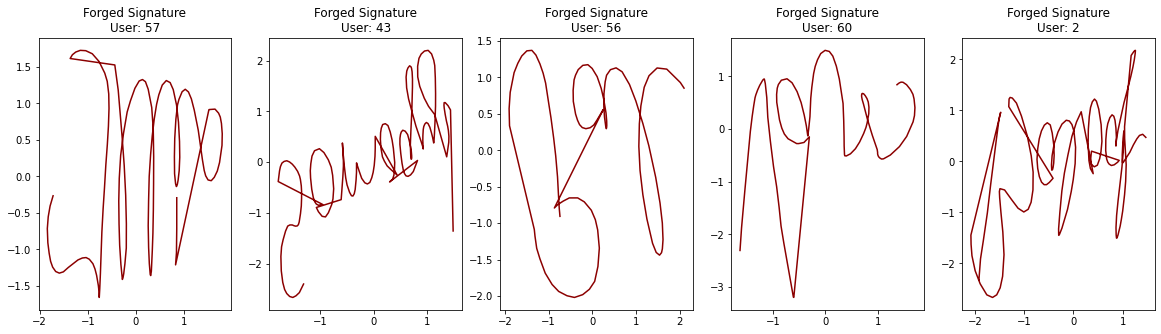

In [15]:
import random
from processMobisig import loadTrainQuestionnedMOBISIG

def signature_plot(users_index = [random.randint(0, 60) for p in range(0, 5)]):
    """[Function returns random sets of genuine and fake signatures from the MOBISIQ data using 
    the user index feature]

    Args:
        users_index (list, optional): [The user index is the access to specific users in the database]. 
        Defaults to [random.randint(0, 60) for p in range(0, 5)].
    Returns:
        [Matplotlib plot]: [Plot of fake and genuine signatures for specific users]
    """
    # initiate 5 random users
    users_index = [random.randint(0, 60) for p in range(0, 5)]
    ntrain = 5

    # load data
    def load_data(idx):
        x_train, x_test = loadTrainQuestionnedMOBISIG(luid[idx], ntrain=ntrain, path=path)[0:2]
        return x_train[1], x_test[1]

    
    fig, axs = plt.subplots(1, 5, figsize = (20, 5))

    for i, ax in zip(users_index, axs.ravel()):
        real_sign = load_data(i)[0]
        plt.plot(real_sign[:, 0], real_sign[:, 1], c = "blue")
        plt.title(f"Genuine Signature\nUser: {i}")
        plt.sca(ax=ax)
    
    fig, axes = plt.subplots(1, 5, figsize = (20, 5))

    for i, ax in zip(users_index, axes.ravel()):
        fake_sign = load_data(i)[1]
        plt.plot(fake_sign[:, 0], fake_sign[:, 1], c = 'darkred')
        plt.title(f"Forged Signature\nUser: {i}")
        plt.sca(ax=ax)

# filter out deprecation warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# show signature plots
signature_plot()

#### Compute distance features

In [16]:
#01: Compute the mean of the train set signatures
def average_signature(arrs, features):
    
    """[
        Function computes the average of the point drawn in each signature file.
        Reference: https://stackoverflow.com/questions/10058227/calculating-mean-of-arrays-with-different-lengths
        ]

    Args:
        arrs ([type: Numpy array]): [array containing the genuine signature in the train set]
        features ([str]): [index value indicating the features of the signature data, you intend to average.]

    Returns:
        [numpy array]: [mean and standard deviation of the 5 signature arrays]
    """   

    lens = [len(i) for i in arrs]
    # initiate Nan Array to store the structure of the new array at a later step. 
    init_arr = np.full((np.max(lens), len(arrs)), np.nan)
    avg_list = []
    std_list = []

    # extract structure of new arrays to compute 
    for idx in features:
        out_arr = init_arr.copy()
        new_array = [arr[:, idx] for arr in arrs]
        
        for idx, arr in enumerate(new_array):
            out_arr[:len(arr), idx] = arr
        
        # compute average and standard deviation arrays
        std_list.append(np.nanstd(out_arr, axis= -1))
        avg_list.append(np.nanmean(out_arr, axis = -1))
        
    return np.stack(avg_list, axis = -1), np.stack(std_list, axis = -1)

In [17]:
def processProblem(X_train, X_test, y_test, features=['x', 'y', 'pressure'], dtfn='euclidean', kdtw_sigma=1.0):
    """
    Obtain temporal similarity features to train the 1-NN classifier
    """
    # 1. signature features
    tffeatures = {'x': 0, 'y': 1, 'pressure': 2, 'x_velocity': 3, 'y_velocity': 4}

    index_features = [tffeatures[ft] for ft in features]

    # 2. Convert np.array(np.array) to list(np.array)  filter according to features
    train_arrs = X_train.tolist()
    train_narrs = [arr[:, index_features] for arr in train_arrs]

    test_arrs = X_test.tolist()
    test_narrs = [arr[:, index_features] for arr in test_arrs]
    
    y_test = [0 if value == 'F' else 1 for value in y_test]
    
    # 3. merge all the train signatures
    mean_sign, error = average_signature(arrs = train_narrs, features = index_features)
    
    # 4. Estimate the similarity ("distance") with Xtest dataset
    if dtfn == 'euclidean':
        final_feature = []
        for test_narr in test_narrs:          
            min_distance = []
            for point in mean_sign:
                mind = np.min(np.sqrt(np.apply_along_axis(np.sum, 1, (point - test_narr)**2)))
                min_distance.append(mind)
            final_feature.append(np.mean(np.array(min_distance)))
        final_feature_np = np.array(final_feature)
    if dtfn == 'frechet':
        final_feature = []
        for  test_narr in test_narrs:
            frechet_dist = frechet.frechet(mean_sign, test_narr)
            final_feature.append(frechet_dist)
        final_feature_np = np.array(final_feature)
    if dtfn == 'dtw':
        final_feature = []
        dtw_dist = [dtw(test_narr, mean_sign, distance_only=True) for test_narr in test_narrs]
        for dist in dtw_dist:
            final_feature.append(dist.distance)
        final_feature_np = np.array(final_feature)
    if dtfn == 'kdtw':
        final_feature = []
        for  test_narr in test_narrs:
            kdtw_dist = kdtw(mean_sign, test_narr, sigma = kdtw_sigma)
            final_feature.append(kdtw_dist)
        final_feature_np = np.array(final_feature)

    return final_feature_np, y_test

In [18]:
def loadallusers(luid, ntrain=5, features=['x', 'y'], dtfn='euclidean', outputdir=path):
    """[loadallusers function loops throough the user data in the MOBISIQ database and 
    implements the processProblem function. Additionally, it stores the information in dataframe, 
    exported to csv stored in the specified directory.]

    Args:
        luid ([type]): [description]
        ntrain (int, optional): [description]. Defaults to 5.
        features (list, optional): [description]. Defaults to ['x', 'y'].
        dtfn (str, optional): [description]. Defaults to 'euclidean'.
        outputdir (str, optional): [description]. Defaults to '~/.'.

    Returns:
        [type]: [description]
    """
    # store features for all users
    
    results_list = []
    
    for uid in luid:
        print("loading problem for user:", uid)
        X_train, X_test, y_test = loadTrainQuestionnedMOBISIG(uid, ntrain=ntrain, path="")    
        x, target = processProblem(X_train, X_test, y_test, features = features, dtfn = dtfn)
        userid = pathlib.Path(uid).stem
        results_list.append(pd.DataFrame({'user': userid, 'feature': x, 'target': target}))
        
    results_df = pd.concat(results_list)
    output = "%s/%s_results.csv" % (outputdir , dtfn)
    results_df.to_csv(output)
    return True

#### Process all the 83 tasks sequentially. 

In [13]:
# set the correct path:
# set the current path to the data path to allow for the sequential processing of data input
path0='C:/Users/rufai/OneDrive/Desktop/School/UBS/Big Data/Data Mining/Time Elastic Kernels'
path=path0 + '/MOBISIG/'
os.chdir(path)
print('path:',path)
luid = glob.glob("USER*")
luid.sort()

path: C:/Users/rufai/OneDrive/Desktop/School/UBS/Big Data/Data Mining/Time Elastic Kernels/MOBISIG/


In [14]:
# Create similarity features for each distance.
luid = [str(x) for x in pathlib.Path(path).glob("USER*")]

# loadallusers(luid, ntrain=5, features=['x', 'y'], dtfn='euclidean')
# loadallusers(luid, ntrain=5, features=['x', 'y'], dtfn='frechet')
# loadallusers(luid, ntrain=5, features=['x', 'y'], dtfn='dtw')

In [19]:
#Load the previous results of the similarity features created from previous run of the code
import zipfile
destination = 'C:\\Users\\rufai\\OneDrive\\Desktop\\School\\UBS\\Big Data\\Data Mining\\Time Elastic Kernels\\results.zip'
directory_to_extract_to = "C:\\Users\\rufai\\OneDrive\\Desktop\\School\\UBS\\Big Data\\Data Mining\\Time Elastic Kernels\\"

with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

#### Compare model performances
The following evaluation metrics were used: 
- Area under the ROC Curve (AUC),
- Average Precision (AP), 
- Equal Error Rate (EER). 

In [16]:
# functions to create metric matrices for extracting model performance
def (dataset):
    user_colum = dataset.user.replace("USER", "", regex=True)
    dataset.user = pd.Series(["USER%02d" % int(user_colum[index]) for index in range(len(dataset.user))])
    return dataset

def compute_eer(distances, labels):
    # Calculate evaluation metrics
    fprs, tprs, _ = metrics.roc_curve(labels, distances)
    eer = fprs[np.nanargmin(np.absolute((1 - tprs) - fprs))]
    return eer

def get_matrix_metric(model, dataset, metric='auc'):
    dataset = pd.read_csv(dataset)
    dataset = fix_user_name(dataset)
    users = list(set(dataset['user']))
 
    all_user_results = dict()
    for user in users:
        #print("processing point: %s" % user)
        #  train your model
        train = dataset[dataset.user == user]
        X, y = train['feature'].to_numpy().reshape(-1, 1), train['target']    
        model.fit(X, y)
        
        # Create a test set excluding the current user (82 len)
        test_users = [xuser for xuser in users if not user in xuser]
        #  Evaluate your model in the other users
        test_results = list()
        for test_user in test_users:
            test = dataset[dataset.user == test_user]
            Xtest, ytest = test['feature'].to_numpy().reshape(-1, 1), test['target']
            ypred = model.predict(Xtest)
            if metric == 'auc':
                fpr, tpr, _ = metrics.roc_curve(ytest, ypred)
                rmetric = metrics.auc(fpr, tpr)
            elif metric == 'ap':
                rmetric = average_precision_score(ytest, ypred)
            elif metric == 'eer':
                rmetric = average_precision_score(ypred, ytest)
            else:
                compute_eer(ytest, ypred)
                pass
            test_results.append(rmetric)
        # add -999 to the current user
        user_index = int(user.replace("USER", "")) - 1
        test_results.insert(user_index, -999)
        all_user_results.update({user:test_results})
    od = collections.OrderedDict(sorted(all_user_results.items()))
    return pd.DataFrame(od)        

def create_all_matrices():
    neigh = KNeighborsClassifier(n_neighbors=2)
    hmetrics = ['auc', 'ap', 'eer']

    matrix_evaluation_euclidean = list()
    for metric in hmetrics:
      matrix_evaluation_euclidean.append(
          get_matrix_metric(neigh, './results/euclidean_results.csv', metric = metric)
      )
    matrix_evaluation_euclidean =  {'auc': matrix_evaluation_euclidean[0], 'ap': matrix_evaluation_euclidean[1], 'eer': matrix_evaluation_euclidean[2]}

    matrix_evaluation_frechet = list()
    for metric in hmetrics:
      matrix_evaluation_frechet.append(
          get_matrix_metric(neigh, './results/frechet_results.csv', metric = metric)
      )
    matrix_evaluation_frechet =  {'auc': matrix_evaluation_frechet[0], 'ap': matrix_evaluation_frechet[1], 'eer': matrix_evaluation_frechet[2]}

    matrix_evaluation_kdtw = list()
    for metric in hmetrics:
      matrix_evaluation_kdtw.append(
          get_matrix_metric(neigh, 'results/kdtw_results.csv', metric = metric)
      )
    matrix_evaluation_kdtw =  {'auc': matrix_evaluation_kdtw[0], 'ap': matrix_evaluation_kdtw[1], 'eer': matrix_evaluation_kdtw[2]}

    matrix_evaluation_dtw = list()
    for metric in hmetrics:
      matrix_evaluation_dtw.append(
          get_matrix_metric(neigh, './results/dtw_results.csv', metric = metric)
      )
    matrix_evaluation_dtw =  {'auc': matrix_evaluation_dtw[0], 'ap': matrix_evaluation_dtw[1], 'eer': matrix_evaluation_dtw[2]}

    return {
        'matrix_evaluation_euclidean': matrix_evaluation_euclidean,
        'matrix_evaluation_frechet': matrix_evaluation_frechet,
        'matrix_evaluation_dtw': matrix_evaluation_dtw,
        'matrix_evaluation_kdtw': matrix_evaluation_kdtw,
    }

In [17]:
os.chdir('C:\\Users\\rufai\\OneDrive\\Desktop\\School\\UBS\\Big Data\\Data Mining\\Time Elastic Kernels\\')

In [21]:
# Estimate the matrix metrics
matrices_evaluation = create_all_matrices()
with open('results/mtx_evaluation.pickle', 'wb') as handle:
    pickle.dump(matrices_evaluation, handle, protocol=pickle.HIGHEST_PROTOCOL)

C:\Users\rufai\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\rufai\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\rufai\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\rufai\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\rufai\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\rufai\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\rufai\anaconda3\lib\site-packages\sklearn\m

In [19]:
def create_m():
    neigh = KNeighborsClassifier(n_neighbors=2)
    hmetrics = ['auc', 'ap', 'eer']

    matrix_evaluation_euclidean = list()
    for metric in hmetrics:
      matrix_evaluation_euclidean.append(
          get_matrix_metric(neigh, './results/euclidean_results.csv', metric = metric)
      )
    matrix_evaluation_euclidean =  {'auc': matrix_evaluation_euclidean[0], 'ap': matrix_evaluation_euclidean[1], 'eer': matrix_evaluation_euclidean[2]}
    return matrix_evaluation_euclidean


h = create_m()

C:\Users\rufai\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\rufai\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\rufai\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\rufai\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\rufai\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\rufai\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\rufai\anaconda3\lib\site-packages\sklearn\m

#### Visualize model comparison outcomes

NameError: name 'matrices_evaluation' is not defined

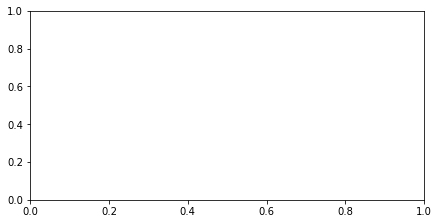

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24,16))

# EUCLIDEAN - display the results
plt.subplot(431)
allm1 = matrices_evaluation['matrix_evaluation_euclidean']['auc'].to_numpy().flatten()
allm1[allm1 == - 999] = np.nan
plt.hist(allm1)
plt.title("Euclidean distance - AUC")

plt.subplot(431)
allm2 = matrices_evaluation['matrix_evaluation_euclidean']['ap'].to_numpy().flatten()
allm2[allm2 == - 999] = np.nan
plt.hist(allm2)
plt.title("Euclidean distance - AP")

plt.subplot(431)
allm3 = matrices_evaluation['matrix_evaluation_euclidean']['eer'].to_numpy().flatten()
allm3[allm3 == - 999] = np.nan
plt.hist(allm3)
plt.title("Euclidean distance - EER")

Text(0.5, 1.0, 'DTW distance - EER')

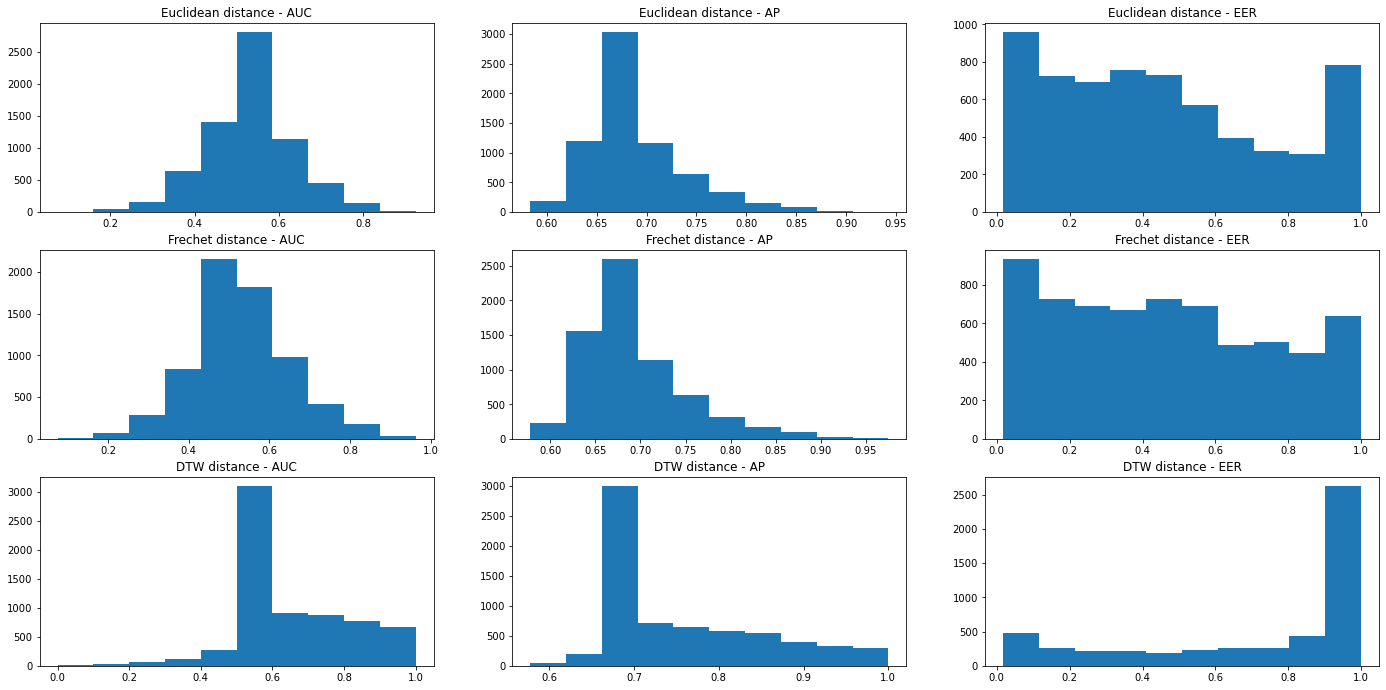

In [25]:
# Display AUC, EER and AP

import matplotlib.pyplot as plt

plt.figure(figsize=(24,16))

# EUCLIDEAN - display the results
plt.subplot(431)
allm1 = matrices_evaluation['matrix_evaluation_euclidean']['auc'].to_numpy().flatten()
allm1[allm1 == - 999] = np.nan
plt.hist(allm1)
plt.title("Euclidean distance - AUC")

plt.subplot(432)
allm2 = matrices_evaluation['matrix_evaluation_euclidean']['ap'].to_numpy().flatten()
allm2[allm2 == - 999] = np.nan
plt.hist(allm2)
plt.title("Euclidean distance - AP")

plt.subplot(433)
allm3 = matrices_evaluation['matrix_evaluation_euclidean']['eer'].to_numpy().flatten()
allm3[allm3 == - 999] = np.nan
plt.hist(allm3)
plt.title("Euclidean distance - EER")


# FRECHET - display the results
plt.subplot(434)
allm1 = matrices_evaluation['matrix_evaluation_frechet']['auc'].to_numpy().flatten()
allm1[allm1 == - 999] = np.nan
plt.hist(allm1)
plt.title("Frechet distance - AUC")

plt.subplot(435)
allm2 = matrices_evaluation['matrix_evaluation_frechet']['ap'].to_numpy().flatten()
allm2[allm2 == - 999] = np.nan
plt.hist(allm2)
plt.title("Frechet distance - AP")

plt.subplot(436)
allm3 = matrices_evaluation['matrix_evaluation_frechet']['eer'].to_numpy().flatten()
allm3[allm3 == - 999] = np.nan
plt.hist(allm3)
plt.title("Frechet distance - EER")


# DTW - display the results
plt.subplot(437)
allm1 = matrices_evaluation['matrix_evaluation_dtw']['auc'].to_numpy().flatten()
allm1[allm1 == - 999] = np.nan
plt.hist(allm1)
plt.title("DTW distance - AUC")

plt.subplot(438)
allm2 = matrices_evaluation['matrix_evaluation_dtw']['ap'].to_numpy().flatten()
allm2[allm2 == - 999] = np.nan
plt.hist(allm2)
plt.title("DTW distance - AP")

plt.subplot(439)
allm3 = matrices_evaluation['matrix_evaluation_dtw']['eer'].to_numpy().flatten()
allm3[allm3 == - 999] = np.nan
plt.hist(allm3)
plt.title("DTW distance - EER")

### Question 03 KDTW: A Regularized Dynamic Time Warping Kernel

https://github.com/pfmarteau/KDTW

KDTW is a python library developed for multivariate time series matching.

-- -- --- -- -- --- -- -- --- -- -- --- -- -- --- -- -- --- -- -- --- -- -- --- -- -- ---

In [26]:
ntrain = 5
# Hyperparameter optimization using cross-validation
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.utils import shuffle

kdtw_sigmas = [0.5, 1, 2.5, 5, 7, 10]

# Create the dataset for USER1 (first task)
X_train, X_test, y_test = loadTrainQuestionnedMOBISIG(luid[0], ntrain=ntrain, path="")
X_test, y_test = shuffle(X_test, y_test, random_state=0)

# Estimate Kfolds
kf = KFold(n_splits=5, shuffle=True)

results_byfold = list()
for train_indices, test_indices in kf.split(y_test):
    print('Train: %s | test: %s' % (train_indices, test_indices))
    best_score = dict()

    # train fold
    xtrain = np.array([X_test[index] for index in train_indices])
    ytrain = np.array([y_test[index] for index in train_indices])
      
    # test fold
    xtest = np.array([X_test[index] for index in test_indices])
    ytest = np.array([y_test[index] for index in test_indices])

    for kdtw_sigma in kdtw_sigmas:

        xtrain01, ytrain01 = processProblem(X_train, xtrain, ytrain, features = ['x', 'y'], dtfn = 'kdtw', kdtw_sigma=kdtw_sigma)
        xtest01, ytest01 = processProblem(X_train, xtest, ytest, features = ['x', 'y'], dtfn = 'kdtw', kdtw_sigma=kdtw_sigma)
        
        # model evaluation
        clf = KNeighborsClassifier(n_neighbors=2).fit(xtrain01.reshape(-1, 1), ytrain01)
        score = clf.score(xtest01.reshape(-1, 1), ytest01)
        
        # save score
        best_score.update({kdtw_sigma:score})
    results_byfold.append(best_score)

best_vparam = {sigma:np.mean([kfold[sigma] for kfold in results_byfold]) for sigma in kdtw_sigmas}

Train: [ 2  3  4  6  8  9 10 11 12 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31 33 34 35 36 37 38 39 40 41 44 46 47 48 49 50 52 53 55 56 57 58 59] | test: [ 0  1  5  7 13 14 32 42 43 45 51 54]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 20 22 23 24 25 28 31
 32 33 34 35 36 37 39 40 42 43 44 45 46 47 48 49 50 51 52 54 55 56 57 59] | test: [15 18 19 21 26 27 29 30 38 41 53 58]
Train: [ 0  1  3  5  6  7  8  9 10 13 14 15 17 18 19 20 21 23 24 25 26 27 28 29
 30 32 33 34 35 36 38 39 40 41 42 43 44 45 47 49 50 51 52 53 54 56 58 59] | test: [ 2  4 11 12 16 22 31 37 46 48 55 57]
Train: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 18 19 21 22 25 26 27 28
 29 30 31 32 33 37 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 57 58] | test: [ 8 17 20 23 24 34 35 36 39 47 56 59]
Train: [ 0  1  2  4  5  7  8 11 12 13 14 15 16 17 18 19 20 21 22 23 24 26 27 29
 30 31 32 34 35 36 37 38 39 41 42 43 45 46 47 48 51 53 54 55 56 57 58 59] | test: [ 3  6  9 10 25 28 33 40 44 49 50 52]


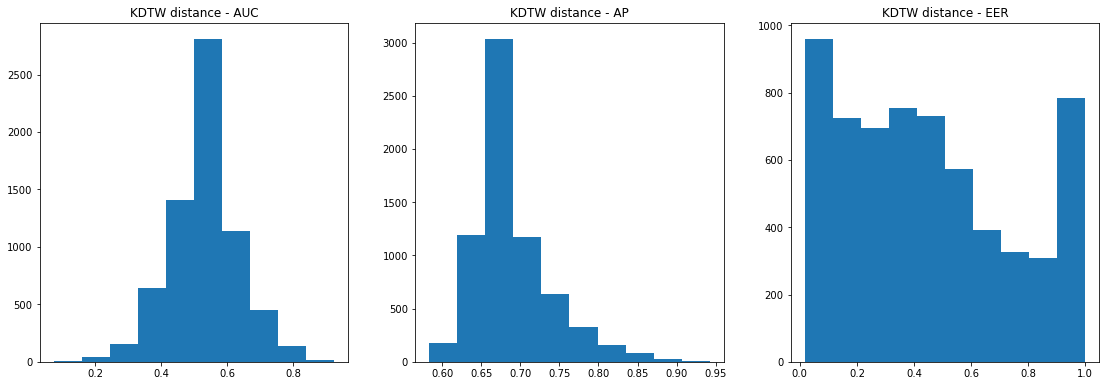

In [27]:
# Display results
# KDTW - display the results
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
allm1 = h['auc'].to_numpy().flatten()
allm1[allm1 == - 999] = np.nan
plt.hist(allm1)
plt.title("KDTW distance - AUC")

plt.subplot(1,3,2)
allm2 = h['ap'].to_numpy().flatten()
allm2[allm2 == - 999] = np.nan
plt.hist(allm2)
plt.title("KDTW distance - AP")

plt.subplot(1,3,3)
allm3 = h['eer'].to_numpy().flatten()
allm3[allm3 == - 999] = np.nan
plt.hist(allm3)
plt.title("KDTW distance - EER")
plt.tight_layout(pad=3.0)
plt.show()

### Question 04: Critical Difference Diagrams using a combination of Friedman's test and a post-hoc analysis based on Wilcoxon-Holm method. 

https://github.com/hfawaz/cd-diagram




In [28]:
# draw_cd_diagram function

import numpy as np
import pandas as pd
import matplotlib

matplotlib.use('agg')
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'

import operator
import math
from scipy.stats import wilcoxon
from scipy.stats import friedmanchisquare
import networkx

# inspired from orange3 https://docs.orange.biolab.si/3/data-mining-library/reference/evaluation.cd.html
def graph_ranks(avranks, names, p_values, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, labels=False, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.
    Needs matplotlib to work.
    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.
    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
        labels (bool, optional): if set to `True`, the calculated avg rank
        values will be displayed
    """
    try:
        import matplotlib
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.
        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]
        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    nnames = names
    ssums = sums

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=2)

    bigtick = 0.3
    smalltick = 0.15
    linewidth = 2.0
    linewidth_sign = 4.0

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=2)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom", size=16)

    k = len(ssums)

    def filter_names(name):
        return name

    space_between_names = 0.24

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + 0.3, chei - 0.075, format(ssums[i], '.4f'), ha="right", va="center", size=10)
        text(textspace - 0.2, chei, filter_names(nnames[i]), ha="right", va="center", size=16)

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + scalewidth - 0.3, chei - 0.075, format(ssums[i], '.4f'), ha="left", va="center", size=10)
        text(textspace + scalewidth + 0.2, chei, filter_names(nnames[i]),
             ha="left", va="center", size=16)

    # no-significance lines
    def draw_lines(lines, side=0.05, height=0.1):
        start = cline + 0.2

        for l, r in lines:
            line([(rankpos(ssums[l]) - side, start),
                  (rankpos(ssums[r]) + side, start)],
                 linewidth=linewidth_sign)
            start += height
            print('drawing: ', l, r)

    # draw_lines(lines)
    start = cline + 0.2
    side = -0.02
    height = 0.1

    # draw no significant lines
    # get the cliques
    cliques = form_cliques(p_values, nnames)
    i = 1
    achieved_half = False
    print(nnames)
    for clq in cliques:
        if len(clq) == 1:
            continue
        print(clq)
        min_idx = np.array(clq).min()
        max_idx = np.array(clq).max()
        if min_idx >= len(nnames) / 2 and achieved_half == False:
            start = cline + 0.25
            achieved_half = True
        line([(rankpos(ssums[min_idx]) - side, start),
              (rankpos(ssums[max_idx]) + side, start)],
             linewidth=linewidth_sign)
        start += height


def form_cliques(p_values, nnames):
    """
    This method forms the cliques
    """
    # first form the numpy matrix data
    m = len(nnames)
    g_data = np.zeros((m, m), dtype=np.int64)
    for p in p_values:
        if p[3] == False:
            i = np.where(nnames == p[0])[0][0]
            j = np.where(nnames == p[1])[0][0]
            min_i = min(i, j)
            max_j = max(i, j)
            g_data[min_i, max_j] = 1

    g = networkx.Graph(g_data)
    return networkx.find_cliques(g)


def draw_cd_diagram(df_perf=None, alpha=0.05, title=None, labels=False):
    """
    Draws the critical difference diagram given the list of pairwise classifiers that are
    significant or not
    """
    p_values, average_ranks, _ = wilcoxon_holm(df_perf=df_perf, alpha=alpha)

    print(average_ranks)

    for p in p_values:
        print(p)


    graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
                cd=None, reverse=True, width=9, textspace=1.5, labels=labels)

    font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 22,
        }
    if title:
        plt.title(title,fontdict=font, y=0.9, x=0.5)
    plt.savefig('cd-diagram.png',bbox_inches='tight')

def wilcoxon_holm(alpha=0.05, df_perf=None):
    """
    Applies the wilcoxon signed rank test between each pair of algorithm and then use Holm
    to reject the null's hypothesis
    """
    print(pd.unique(df_perf['classifier_name']))
    # count the number of tested datasets per classifier
    df_counts = pd.DataFrame({'count': df_perf.groupby(
        ['classifier_name']).size()}).reset_index()
    # get the maximum number of tested datasets
    max_nb_datasets = df_counts['count'].max()
    # get the list of classifiers who have been tested on nb_max_datasets
    classifiers = list(df_counts.loc[df_counts['count'] == max_nb_datasets]
                       ['classifier_name'])
    # test the null hypothesis using friedman before doing a post-hoc analysis
    friedman_p_value = friedmanchisquare(*(
        np.array(df_perf.loc[df_perf['classifier_name'] == c]['accuracy'])
        for c in classifiers))[1]
    if friedman_p_value >= alpha:
        # then the null hypothesis over the entire classifiers cannot be rejected
        print('the null hypothesis over the entire classifiers cannot be rejected')
        exit()
    # get the number of classifiers
    m = len(classifiers)
    # init array that contains the p-values calculated by the Wilcoxon signed rank test
    p_values = []
    # loop through the algorithms to compare pairwise
    for i in range(m - 1):
        # get the name of classifier one
        classifier_1 = classifiers[i]
        # get the performance of classifier one
        perf_1 = np.array(df_perf.loc[df_perf['classifier_name'] == classifier_1]['accuracy']
                          , dtype=np.float64)
        for j in range(i + 1, m):
            # get the name of the second classifier
            classifier_2 = classifiers[j]
            # get the performance of classifier one
            perf_2 = np.array(df_perf.loc[df_perf['classifier_name'] == classifier_2]
                              ['accuracy'], dtype=np.float64)
            # calculate the p_value
            p_value = wilcoxon(perf_1, perf_2, zero_method='pratt')[1]
            # appen to the list
            p_values.append((classifier_1, classifier_2, p_value, False))
    # get the number of hypothesis
    k = len(p_values)
    # sort the list in acsending manner of p-value
    p_values.sort(key=operator.itemgetter(2))

    # loop through the hypothesis
    for i in range(k):
        # correct alpha with holm
        new_alpha = float(alpha / (k - i))
        # test if significant after holm's correction of alpha
        if p_values[i][2] <= new_alpha:
            p_values[i] = (p_values[i][0], p_values[i][1], p_values[i][2], True)
        else:
            # stop
            break
    # compute the average ranks to be returned (useful for drawing the cd diagram)
    # sort the dataframe of performances
    sorted_df_perf = df_perf.loc[df_perf['classifier_name'].isin(classifiers)]. \
        sort_values(['classifier_name', 'dataset_name'])
    # get the rank data
    rank_data = np.array(sorted_df_perf['accuracy']).reshape(m, max_nb_datasets)

    # create the data frame containg the accuracies
    df_ranks = pd.DataFrame(data=rank_data, index=np.sort(classifiers), columns=
    np.unique(sorted_df_perf['dataset_name']))

    # number of wins
    dfff = df_ranks.rank(ascending=False)
    print(dfff[dfff == 1.0].sum(axis=1))

    # average the ranks
    average_ranks = df_ranks.rank(ascending=False).mean(axis=1).sort_values(ascending=False)
    # return the p-values and the average ranks
    return p_values, average_ranks, max_nb_datasets

['euclidean' 'frechet' 'dtw' 'kdtw']
dtw          59.0
euclidean    10.0
frechet      11.0
kdtw          0.0
dtype: float64
kdtw         4.000000
euclidean    2.343373
frechet      2.216867
dtw          1.439759
dtype: float64
('euclidean', 'kdtw', 2.051355140306704e-15, True)
('frechet', 'kdtw', 2.329696107312421e-15, True)
('dtw', 'kdtw', 2.362697990921114e-15, True)
('dtw', 'euclidean', 2.92326342830148e-10, True)
('dtw', 'frechet', 4.3975348350264786e-10, True)
('euclidean', 'frechet', 0.3411375546074068, False)
Index(['kdtw', 'euclidean', 'frechet', 'dtw'], dtype='object')
[1, 2]


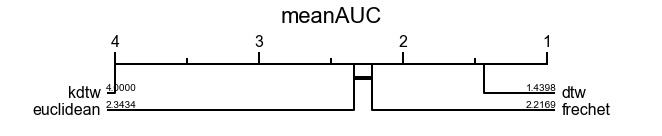

In [29]:
# df1 
meanAUC = matrices_evaluation['matrix_evaluation_euclidean']['auc'].apply(np.nanmedian)
dataset_name = np.array(meanAUC.index)
classifier_name = 'euclidean'
euclidean_df = pd.DataFrame({'classifier_name':classifier_name, 'dataset_name':dataset_name, 'accuracy':meanAUC})

# df2
meanAUC = matrices_evaluation['matrix_evaluation_frechet']['auc'].apply(np.nanmedian)
dataset_name = np.array(meanAUC.index)
classifier_name = 'frechet'
frechet_df = pd.DataFrame({'classifier_name':classifier_name, 'dataset_name':dataset_name, 'accuracy':meanAUC})

# df3
meanAUC = matrices_evaluation['matrix_evaluation_dtw']['auc'].apply(np.nanmedian)
dataset_name = np.array(meanAUC.index)
classifier_name = 'dtw'
dtw_df = pd.DataFrame({'classifier_name':classifier_name, 'dataset_name':dataset_name, 'accuracy':meanAUC})

# df4
meanAUC = matrices_evaluation['matrix_evaluation_kdtw']['auc'].apply(np.nanmedian)
dataset_name = np.array(meanAUC.index)
classifier_name = 'kdtw'
kdtw_df = pd.DataFrame({'classifier_name':classifier_name, 'dataset_name':dataset_name, 'accuracy':meanAUC})

final_db = pd.concat([euclidean_df, frechet_df, dtw_df, kdtw_df])
draw_cd_diagram(df_perf=final_db, title='meanAUC', labels=True)

#### Evaluate the processing time elapsed for each of the distance metrics -- Euclidean, Frechet, DTW and KDTW. 

In [100]:
os.chdir("C:\\Users\\rufai\\OneDrive\\Desktop\\School\\UBS\\Big Data\\Data Mining\\Time Elastic Kernels\\")
os.getcwd()

'C:\\Users\\rufai\\OneDrive\\Desktop\\School\\UBS\\Big Data\\Data Mining\\Time Elastic Kernels'

In [113]:
# functions to test the CPUT Time used**
from time import perf_counter

def perform_time(func):
    """
    Decorator to retrieve the CPU Time Used.
    Source: https://stackoverflow.com/questions/1622943/timeit-versus-timing-decorator
    """
    def wrapper_time(*args, **kwargs):
        start = perf_counter()
        result = func(*args, **kwargs)
        end = perf_counter()
        elapse_tim = end - start
        
        print(f"Elapsed time:", elapse_tim)
            
        return result, elapse_tim
    return wrapper_time

def timer_tester(tries=2):
    @perform_time
    def euclidean_timer():
        path= "./MOBISIQ"
        luid = [str(x) for x in pathlib.Path(path).glob("USER*")]
        loadallusers([luid[0]], ntrain=5, features=['x', 'y'], dtfn='euclidean')
        return True

    @perform_time
    def frechet_timer():
        path= "./MOBISIQ"
        luid = [str(x) for x in pathlib.Path(path).glob("USER*")]
        loadallusers([luid[0]], ntrain=5, features=['x', 'y'], dtfn='frechet')
        return True

    @perform_time
    def kdtw_timer():
        path= "./MOBISIQ"
        luid = [str(x) for x in pathlib.Path(path).glob("USER*")]
        loadallusers([luid[0]], ntrain=5, features=['x', 'y'], dtfn='kdtw')
        return True

    @perform_time
    def dtw_timer():
        path= "./MOBISIQ"
        luid = [str(x) for x in pathlib.Path(path).glob("USER*")]
        loadallusers([luid[0]], ntrain=5, features=['x', 'y'], dtfn='dtw')
        return True

    # euclidean
    euclidean_time_list = list()
    for _ in range(tries):
        _, euclidean_time = euclidean_timer()
        euclidean_time_list.append(euclidean_time)

    # frechet
    frechet_time_list = list()
    for _ in range(tries):
        _, frechet_time = frechet_timer()
        frechet_time_list.append(frechet_time)


    # dtw
    dtw_time_list = list()
    for _ in range(tries):
        _, dtw_time = dtw_timer()
        dtw_time_list.append(dtw_time)
    

    # kdtw
    kdtw_time_list = list()
    for _ in range(tries):
        _, kdtw_time = kdtw_timer()
        kdtw_time_list.append(kdtw_time)
        
    return {
        'euclidean': euclidean_time_list,
        'frechet': frechet_time_list,
        'dtw': dtw_time_list,
        'kdtw': kdtw_time_list
    }

In [120]:
@perform_time
def loader():
    return loadallusers(luid, ntrain=5, features=['x', 'y'], dtfn='euclidean')

In [121]:
loader()

loading problem for user: C:\Users\rufai\OneDrive\Desktop\School\UBS\Big Data\Data Mining\Time Elastic Kernels\MOBISIG\USER1
loading problem for user: C:\Users\rufai\OneDrive\Desktop\School\UBS\Big Data\Data Mining\Time Elastic Kernels\MOBISIG\USER10
loading problem for user: C:\Users\rufai\OneDrive\Desktop\School\UBS\Big Data\Data Mining\Time Elastic Kernels\MOBISIG\USER11
loading problem for user: C:\Users\rufai\OneDrive\Desktop\School\UBS\Big Data\Data Mining\Time Elastic Kernels\MOBISIG\USER12
loading problem for user: C:\Users\rufai\OneDrive\Desktop\School\UBS\Big Data\Data Mining\Time Elastic Kernels\MOBISIG\USER13
loading problem for user: C:\Users\rufai\OneDrive\Desktop\School\UBS\Big Data\Data Mining\Time Elastic Kernels\MOBISIG\USER14
loading problem for user: C:\Users\rufai\OneDrive\Desktop\School\UBS\Big Data\Data Mining\Time Elastic Kernels\MOBISIG\USER15
loading problem for user: C:\Users\rufai\OneDrive\Desktop\School\UBS\Big Data\Data Mining\Time Elastic Kernels\MOBISIG\

(True, 1499.8703098999995)

In [124]:
@perform_time
def dtw_timer():
    luid = [str(x) for x in pathlib.Path(path).glob("USER*")]
    loadallusers([luid[0]], ntrain=5, features=['x', 'y'], dtfn='dtw')
    return True

dtw_time = dtw_timer()

loading problem for user: C:\Users\rufai\OneDrive\Desktop\School\UBS\Big Data\Data Mining\Time Elastic Kernels\MOBISIG\USER1
Elapsed time: 0.274097299999994


In [104]:
luid = [str(x) for x in pathlib.Path(path).glob("USER*")]

In [115]:
def perform_time(func):
    """
    Decorator to retrieve the CPU Time Used.
    Source: https://stackoverflow.com/questions/1622943/timeit-versus-timing-decorator
    """
    def wrapper_time(*args, **kwargs):
        start = perf_counter()
        result = func(*args, **kwargs)
        end = perf_counter()
        elapse_tim = end - start
        
        print(f"Elapsed time:", elapse_tim)
            
        return result, elapse_tim
    return wrapper_time

In [118]:
@perform_time
def lid():
    return [str(x) for x in pathlib.Path(path).glob("USER*")]

In [114]:
timetest = timer_tester(tries=10)

IndexError: list index out of range

In [ ]:
timetest = timer_tester(tries=10)

plt.figure(figsize=(6, 6))
plt.boxplot([timetest['euclidean'], timetest['kdtw'], timetest['dtw'], timetest['frechet']])
plt.xticks([1, 2, 3, 4], ['Euclidean\n(Python)', 'KDTW\n(Python)', 'DTW\n(C++)', 'Frechet\n(Python)'])
plt.show()

ValueError: No objects to concatenate

In [2]:
[luid[0]]

NameError: name 'luid' is not defined

In [50]:
for x in pathlib.Path("~\MOBISIG\\").glob("USER*"):
    print(str(x))

**Be careful!**

It doesn't mean that *dtw* is faster than *kdtw*.  

The *dtw* algorithm employed in this report utilizes a C++ implementation. Theorically, *kdtw* must be faster than *dtw*.